In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! pip install diffusers transformers datasets accelerate ftfy huggingface-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.3 MB/s eta 0:00:00


In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
from torch.nn import functional as F
import torchvision 
from torchvision import transforms 
from diffusers import DDPMPipeline,DDIMScheduler
from accelerate import Accelerator 
import os 
from tqdm.auto import tqdm 
from PIL import Image 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
model_id = "google/ddpm-celebahq-256"
image_pipe = DDPMPipeline.from_pretrained(model_id).to(device)

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [8]:
scheduler = DDIMScheduler.from_pretrained(model_id)
scheduler.set_timesteps(num_inference_steps=40)

0it [00:00, ?it/s]

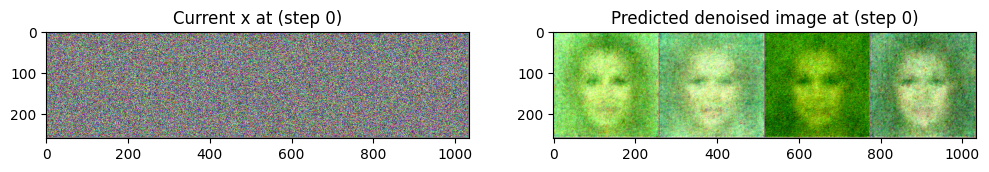

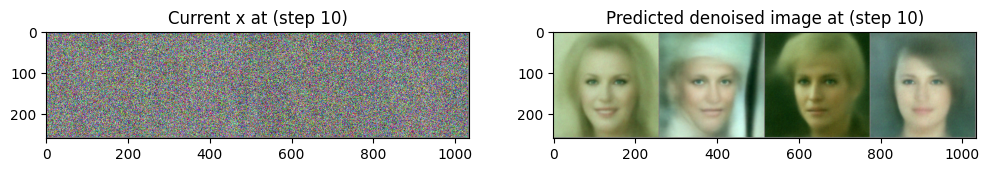

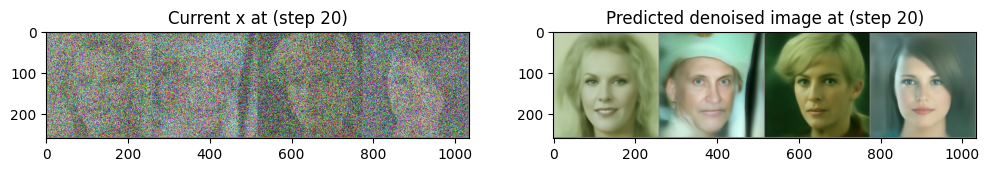

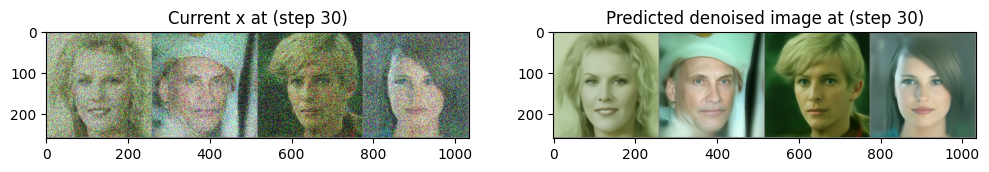

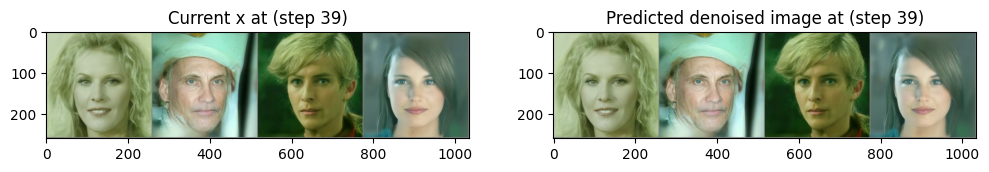

In [9]:
x = torch.randn(4,3,256,256).to(device)

for i,t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x,t)
    
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input,t)['sample']

    scheduler_output = scheduler.step(noise_pred,t,x)
    x = scheduler_output.prev_sample 

    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig,axs = plt.subplots(1,2,figsize=(12,5))
        grid = torchvision.utils.make_grid(x,nrow=4).permute(1,2,0)
        axs[0].set_title(f'Current x at (step {i})')
        axs[0].imshow(grid.cpu().clip(-1,1)* 0.5 +0.5)

        pred_x0 = scheduler_output.pred_original_sample 
        grid = torchvision.utils.make_grid(pred_x0,nrow=4).permute(1,2,0)
        axs[1].set_title(f'Predicted denoised image at (step {i})')
        axs[1].imshow(grid.cpu().clip(-1,1)*0.5 + 0.5)
        plt.show()

In [10]:
image_pipe.scheduler = scheduler

In [12]:
from datasets import load_dataset

dataset_name = 'Norod78/Vintage-Faces-FFHQAligned'
dataset = load_dataset(dataset_name,split='train')

image_size = 256 
batch_size = 4 

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

dataset_infos.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/262M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1498 [00:00<?, ? examples/s]

Previewing batch:


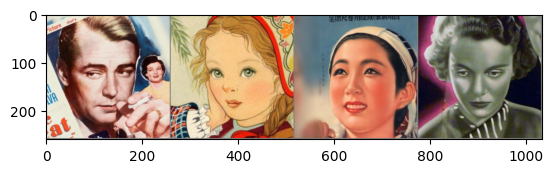

In [13]:
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

  0%|          | 0/375 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 375/375 [09:48<00:00,  1.57s/it]


Epoch 1 average loss: 0.017877
Learning Rate after epoch 1: 0.00000374
Checkpoint saved at epoch 1


100%|██████████| 375/375 [09:48<00:00,  1.57s/it]


Epoch 2 average loss: 0.013113
Learning Rate after epoch 2: 0.00000748
Checkpoint saved at epoch 2


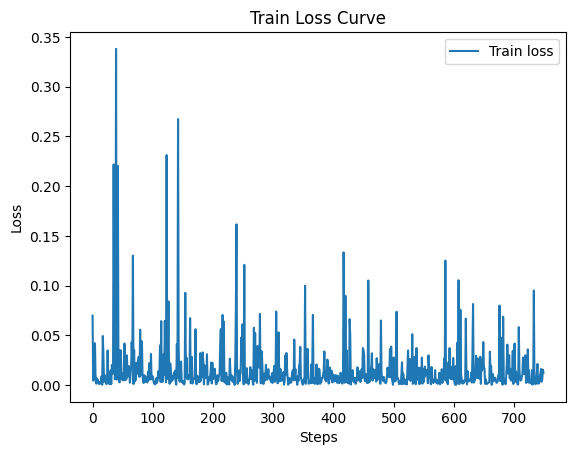

In [14]:
from accelerate import Accelerator 
from diffusers.optimization import get_cosine_schedule_with_warmup
import torch
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize Accelerator
accelerator = Accelerator()
device = accelerator.device

# Training Config
grad_accumulation_steps = 2  
checkpoint_path = 'model_checkpoint.pth'
start_epoch = 0
num_epochs = 2  
losses = []

# Model & Optimizer
model = image_pipe.unet  
lr = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning Rate Scheduler
num_training_steps = len(train_dataloader) * num_epochs  # Total steps
num_warmup_steps = 500  # Adjust based on your training setup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Prepare for multi-GPU training
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler
)

# Load Checkpoint (if exists)
if os.path.exists(checkpoint_path):
    print("Resuming from checkpoint")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])  # Load scheduler state
    start_epoch = checkpoint['epoch'] + 1
    losses = checkpoint['losses']
    print(f"Checkpoint loaded, resuming from epoch {start_epoch}")

# Training Loop
for epoch in range(start_epoch, num_epochs):
    epoch_loss = 0  

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch['images'].to(device)
        bs = clean_images.shape[0]
        noise = torch.randn_like(clean_images).to(clean_images.device)
        timesteps = torch.randint(0, image_pipe.scheduler.num_train_timesteps,
                                  (bs,), device=clean_images.device).long()
        
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)
        
        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)

            accelerator.backward(loss)

            if (step + 1) % grad_accumulation_steps == 0:
                optimizer.step()  # Step optimizer
                lr_scheduler.step()  # Step learning rate scheduler
                optimizer.zero_grad()
            
        losses.append(loss.item())
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1} average loss: {avg_loss:.6f}")

    # Print Learning Rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate after epoch {epoch + 1}: {current_lr:.8f}")

    # Save Checkpoint
    checkpoint = {'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'scheduler_state_dict': lr_scheduler.state_dict(),  # Save scheduler state
                  'losses': losses}
    
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

# Plot Training Loss
plt.plot(losses, label='Train loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Train Loss Curve')
plt.legend()
plt.show()


40it [00:43,  1.10s/it]


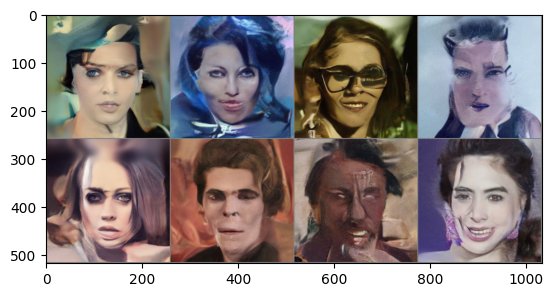

In [15]:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

In [16]:
! pip install open-clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.0 MB/s eta 0:00:0000:0100:01


In [21]:
import open_clip 

clip_model,_,preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu',pretrained='openai')
clip_model.to(device)

tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize( mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711))])



def clip_loss(image,text_features):
    image_features = clip_model.encode_image(tfms(image))
    input_normed = F.normalize(image_features.unsqueeze(1),dim=2)
    embed_normed = F.normalize(text_features.unsqueeze(0),dim=2)
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )  # Squared Great Circle Distance
    return dists.mean()    
    

<ipython-input-24-564aec47be9a>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
1it [00:00,  1.41it/s]

Step: 0 , Guidance loss: 7.901560306549072


26it [00:17,  1.42it/s]

Step: 25 , Guidance loss: 7.209001541137695


50it [00:35,  1.42it/s]


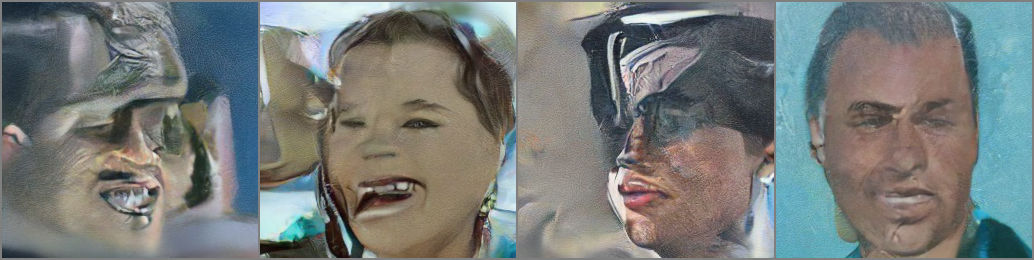

In [24]:
prompt = "A realistic Indian boy in uniform, dramatic lighting, photography"

# Explore changing this
guidance_scale = 8  
n_cuts = 4  

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(
    device
)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = (
        x.detach() + cond_grad * alpha_bar.sqrt()
    )  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

In [29]:
sample_image = torch.randn(4,3,256,256).to(device)
image_features = clip_model.encode_image(tfms(sample_image))
print(type(image_features))

input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
text = open_clip.tokenize([prompt]).to(device)
print(text)


<class 'torch.Tensor'>
tensor([[49406,   320, 16157,  3606,  1876,   530, 11075,   267, 11240,  5799,
           267,  2108, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0')
